In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re

import generate_data as gd

In [3]:
import pylab as plt

In [4]:
# resnet/whole_mm_indiv_data_adv.py using 5 blocks

In [5]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])


In [6]:
block_no = 5
var_name = "geo"
unique_list = [500] #100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]

In [7]:
# For the data generator all variables have to be merged into a single dataset.
# For the data generator all variables have to be merged into a single dataset.
if var_name == 'specific_humidity':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'specific_humidity': ('q', unique_list)}
elif var_name == '2m temp':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        '2m_temperature': ('t2m', None)}
elif var_name == 'solar rad':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'toa_incident_solar_radiation': ('tisr', None)}
elif var_name == 'pot_vort':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'potential_vorticity': ('pv', unique_list)}
elif var_name == 'const':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'constants': ['lat2d', 'orography', 'lsm']}
elif var_name == 'orig':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850])} 
elif var_name == 'temp':
    unique_list.append(850)
    unique_list = sorted(list(dict.fromkeys(unique_list)))
    print(unique_list)
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', unique_list)}
elif var_name == 'geo':
    unique_list.append(500)
    unique_list = sorted(list(dict.fromkeys(unique_list)))
    var_dict = {
        'geopotential': ('z', unique_list),
        'temperature': ('t', [850])}    

# For the data generator all variables have to be merged into a single dataset.
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))


In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        #if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)        
            
bs=32
lead_time=72
output_vars = ['z_500', 't_850']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
#dg_valid = DataGenerator(
#    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std,
                         shuffle=False, output_vars=output_vars)



## Real data

In [9]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [10]:
real_unnorm =y1* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

## geo

In [18]:
pred_ensemble_1 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_geo[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000].npy')
samples = 20
preds_geo_levels = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_1 = []

ens_1 = preds_geo_levels.isel(ens = 0).copy()

ens_rmse_list_1.append(compute_weighted_rmse(ens_1, real_ds).compute())

for i in range(1, len(preds_geo_levels.ens)):
    ens_1 += preds_geo_levels.isel(ens = i).copy()
    ens_rmse_list_1.append(compute_weighted_rmse(ens_1/(i+1), real_ds).compute())

ens_rmse_list_1[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.282
    z        float64 426.4

In [19]:
pred_ensemble_1a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_geo[400, 500, 700, 850].npy')

samples = 20
preds_geo_levelsa = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_1a = []

ens_1a = preds_geo_levelsa.isel(ens = 0).copy()

ens_rmse_list_1a.append(compute_weighted_rmse(ens_1a, real_ds).compute())

for i in range(1, len(preds_geo_levelsa.ens)):
    ens_1a += preds_geo_levelsa.isel(ens = i).copy()
    ens_rmse_list_1a.append(compute_weighted_rmse(ens_1a/(i+1), real_ds).compute())
    
ens_rmse_list_1a[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.351
    z        float64 447.5

In [20]:
pred_ensemble_1b = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_geo[300, 400, 500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_geo_levelsb = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_1b[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_1b[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_1b = []

ens_1b = preds_geo_levelsb.isel(ens = 0).copy()

ens_rmse_list_1b.append(compute_weighted_rmse(ens_1b, real_ds).compute())

for i in range(1, len(preds_geo_levelsb.ens)):
    ens_1b += preds_geo_levelsb.isel(ens = i).copy()
    ens_rmse_list_1b.append(compute_weighted_rmse(ens_1b/(i+1), real_ds).compute())
    
ens_rmse_list_1b[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 435.1
    t        float64 2.298

In [21]:
pred_ensemble_1c = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_geo[300, 400, 500, 600, 700, 850].npy')

samples = 20
preds_geo_levelsc = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1c[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1c[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_1c = []

ens_1c = preds_geo_levelsc.isel(ens = 0).copy()

ens_rmse_list_1c.append(compute_weighted_rmse(ens_1c, real_ds).compute())

for i in range(1, len(preds_geo_levelsc.ens)):
    ens_1c += preds_geo_levelsc.isel(ens = i).copy()
    ens_rmse_list_1c.append(compute_weighted_rmse(ens_1c/(i+1), real_ds).compute())
    
ens_rmse_list_1c[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.308
    z        float64 434.3

In [15]:
ens_1_avg = ens_1c/20
ens_1_avg.to_netcdf('/rds/general/user/mc4117/ephemeral/saved_pred/geo_levels_5_preds.nc')

PermissionError: [Errno 13] Permission denied: b'/rds/general/user/mc4117/ephemeral/saved_pred/geo_levels_5_preds.nc'

In [22]:
pred_ensemble_1d = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_geo[100, 250, 300, 400, 500, 600, 700, 850].npy')

samples = 20
preds_geo_levelsd = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1d[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1d[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_1d = []

ens_1d = preds_geo_levelsd.isel(ens = 0).copy()

ens_rmse_list_1d.append(compute_weighted_rmse(ens_1d, real_ds).compute())

for i in range(1, len(preds_geo_levelsd.ens)):
    ens_1d += preds_geo_levelsd.isel(ens = i).copy()
    ens_rmse_list_1d.append(compute_weighted_rmse(ens_1d/(i+1), real_ds).compute())
    
ens_rmse_list_1d[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.359
    z        float64 440.0

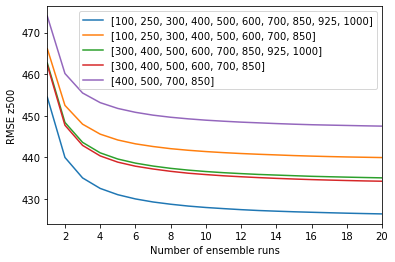

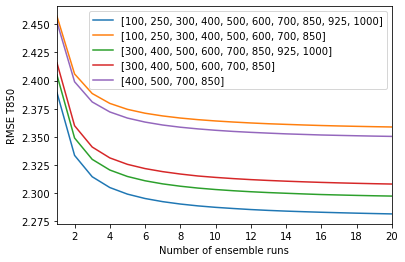

In [23]:
fig, ax = plt.subplots()

from matplotlib.ticker import MaxNLocator

ax.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].z for i in range(len(ens_rmse_list_1))], label = '[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1d))], [ens_rmse_list_1d[i].z for i in range(len(ens_rmse_list_1d))], label = '[100, 250, 300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1b))], [ens_rmse_list_1b[i].z for i in range(len(ens_rmse_list_1b))], label = '[300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1c))], [ens_rmse_list_1c[i].z for i in range(len(ens_rmse_list_1c))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1a))], [ens_rmse_list_1a[i].z for i in range(len(ens_rmse_list_1a))], label = '[400, 500, 700, 850]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE z500')
ax.set_xlim([1,20])
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].t for i in range(len(ens_rmse_list_1))], label = '[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1d))], [ens_rmse_list_1d[i].t for i in range(len(ens_rmse_list_1d))], label = '[100, 250, 300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1b))], [ens_rmse_list_1b[i].t for i in range(len(ens_rmse_list_1b))], label = '[300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1c))], [ens_rmse_list_1c[i].t for i in range(len(ens_rmse_list_1c))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_1a))], [ens_rmse_list_1a[i].t for i in range(len(ens_rmse_list_1a))], label = '[400, 500, 700, 850]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE T850')
ax.set_xlim([1,20])
plt.legend()
plt.show()

## temperature

In [24]:
pred_ensemble_3 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_temp_levels = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_3[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_3[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3 = []

ens_3 = preds_temp_levels.isel(ens = 0).copy()

ens_rmse_list_3.append(compute_weighted_rmse(ens_3, real_ds).compute())

for i in range(1, len(preds_temp_levels.ens)):
    ens_3 += preds_temp_levels.isel(ens = i).copy()
    ens_rmse_list_3.append(compute_weighted_rmse(ens_3/(i+1), real_ds).compute())
ens_rmse_list_3[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 435.6
    t        float64 2.313

In [12]:
pred_ensemble_3a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[300, 400, 500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_temp_levelsa = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_3a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_3a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3a = []

ens_3a = preds_temp_levelsa.isel(ens = 0).copy()

ens_rmse_list_3a.append(compute_weighted_rmse(ens_3a, real_ds).compute())

for i in range(1, len(preds_temp_levelsa.ens)):
    ens_3a += preds_temp_levelsa.isel(ens = i).copy()
    ens_rmse_list_3a.append(compute_weighted_rmse(ens_3a/(i+1), real_ds).compute())
    
ens_rmse_list_3a[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 434.0
    t        float64 2.297

In [13]:
pred_ensemble_3b = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_temp_levelsb = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_3b[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_3b[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3b = []

ens_3b = preds_temp_levelsb.isel(ens = 0).copy()

ens_rmse_list_3b.append(compute_weighted_rmse(ens_3b, real_ds).compute())

for i in range(1, len(preds_temp_levelsb.ens)):
    ens_3b += preds_temp_levelsb.isel(ens = i).copy()
    ens_rmse_list_3b.append(compute_weighted_rmse(ens_3b/(i+1), real_ds).compute())
    
ens_rmse_list_3b[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.35
    z        float64 454.6

In [14]:
pred_ensemble_3c = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[500, 600, 700, 850].npy')

samples = 20
preds_temp_levelsc = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_3c[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_3c[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3c = []

ens_3c = preds_temp_levelsc.isel(ens = 0).copy()

ens_rmse_list_3c.append(compute_weighted_rmse(ens_3c, real_ds).compute())

for i in range(1, len(preds_temp_levelsc.ens)):
    ens_3c += preds_temp_levelsc.isel(ens = i).copy()
    ens_rmse_list_3c.append(compute_weighted_rmse(ens_3c/(i+1), real_ds).compute())
    
ens_rmse_list_3c[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.357
    z        float64 451.3

In [15]:
pred_ensemble_3d = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[300, 400, 500, 600, 700, 850].npy')

samples = 20
preds_temp_levelsd = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_3d[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_3d[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3d = []

ens_3d = preds_temp_levelsd.isel(ens = 0).copy()

ens_rmse_list_3d.append(compute_weighted_rmse(ens_3d, real_ds).compute())

for i in range(1, len(preds_temp_levelsd.ens)):
    ens_3d += preds_temp_levelsd.isel(ens = i).copy()
    ens_rmse_list_3d.append(compute_weighted_rmse(ens_3d/(i+1), real_ds).compute())
    
ens_rmse_list_3d[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.333
    z        float64 436.7

In [ ]:
ens_3_avg = ens_3d/20
ens_3_avg.to_netcdf('/rds/general/user/mc4117/ephemeral/saved_pred/temp_levels_5_preds.nc')

In [16]:
pred_ensemble_3e = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_temp[300, 400, 500, 600, 700, 850, 925].npy')

samples = 20
preds_temp_levelse = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_3e[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_3e[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_3e = []

ens_3e = preds_temp_levelse.isel(ens = 0).copy()

ens_rmse_list_3e.append(compute_weighted_rmse(ens_3e, real_ds).compute())

for i in range(1, len(preds_temp_levelse.ens)):
    ens_3e += preds_temp_levelse.isel(ens = i).copy()
    ens_rmse_list_3e.append(compute_weighted_rmse(ens_3e/(i+1), real_ds).compute())
    
ens_rmse_list_3e[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 442.7
    t        float64 2.342

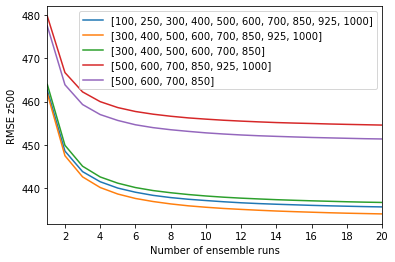

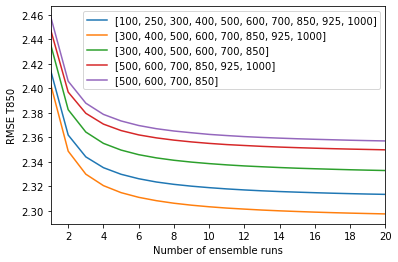

In [26]:
fig, ax = plt.subplots()

from matplotlib.ticker import MaxNLocator

ax.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].z for i in range(len(ens_rmse_list_3))], label = '[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3a))], [ens_rmse_list_3a[i].z for i in range(len(ens_rmse_list_3a))], label = '[300, 400, 500, 600, 700, 850, 925, 1000]')
#ax.plot([i +1 for i in range(len(ens_rmse_list_3e))], [ens_rmse_list_3e[i].z for i in range(len(ens_rmse_list_3e))], label = '[300, 400, 500, 600, 700, 850, 925]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3d))], [ens_rmse_list_3d[i].z for i in range(len(ens_rmse_list_3d))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3b))], [ens_rmse_list_3b[i].z for i in range(len(ens_rmse_list_3b))], label = '[500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3c))], [ens_rmse_list_3c[i].z for i in range(len(ens_rmse_list_3c))], label = '[500, 600, 700, 850]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE z500')
ax.set_xlim([1,20])
plt.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].t for i in range(len(ens_rmse_list_3))], label = '[100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3a))], [ens_rmse_list_3a[i].t for i in range(len(ens_rmse_list_3a))], label = '[300, 400, 500, 600, 700, 850, 925, 1000]')
#ax.plot([i +1 for i in range(len(ens_rmse_list_3e))], [ens_rmse_list_3e[i].t for i in range(len(ens_rmse_list_3e))], label = '[300, 400, 500, 600, 700, 850, 925]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3d))], [ens_rmse_list_3d[i].t for i in range(len(ens_rmse_list_3d))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3b))], [ens_rmse_list_3b[i].t for i in range(len(ens_rmse_list_3b))], label = '[500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_3c))], [ens_rmse_list_3c[i].t for i in range(len(ens_rmse_list_3c))], label = '[500, 600, 700, 850]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE T850')
ax.set_xlim([1,20])
plt.legend()
plt.show()

In [24]:
# just temperature

stack_test_list = [ens_3/20, ens_3a/20, ens_3d/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 426.1
    t        float64 2.278

In [25]:
# just geopotential 

stack_test_list = [ens_1/20, ens_1b/20, ens_1c/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.26
    z        float64 422.1

In [26]:
# all results

stack_test_list = [ens_1/20, ens_1b/20, ens_1c/20, ens_3/20, ens_3a/20, ens_3d/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.258
    z        float64 421.1

optimum [300, 400, 500, 600, 700, 850]